In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, MaxPooling2D, LSTM
import os
from sklearn.preprocessing import StandardScaler
import pandas.io.sql as sqlio
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop, SGD, Adam
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

2024-06-18 13:59:42.459561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Connection

In [2]:
# Database connection parameters
db_params = {
    'host': '',
    'port': '',
    'database': 'postgres',
    'user': '',
    'password': ''
}

# Function to establish a database connection
def get_db_connection(db_params):
    try:
        conn = psycopg2.connect(
            host=db_params['host'],
            port=db_params['port'],
            database=db_params['database'],
            user=db_params['user'],
            password=db_params['password']
        )
        return conn
    except psycopg2.DatabaseError as e:
        print(f"Error: {e}")
        return None

# Function to retrieve data from a specific table
def get_table_data(db_params, table_name):
    conn = get_db_connection(db_params)
    if conn is None:
        return None
    
    try:
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        conn.close()

# Importing/ Preping the Preproccessed table

In [3]:
# Load the training, testing, and validation datasets from the database
train_table_name = 'group12_warehouse.train_table'
test_table_name = 'group12_warehouse.test_table'
validation_table_name = 'group12_warehouse.validation_table'

train_data = get_table_data(db_params, train_table_name)
test_data = get_table_data(db_params, test_table_name)
validation_data = get_table_data(db_params, validation_table_name)

/tmp/ipykernel_3600650/4004516713.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [4]:
# Ensure all data is numeric
def convert_to_numeric(df):
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

# Defining Model

In [5]:
train_data = convert_to_numeric(train_data)
test_data = convert_to_numeric(test_data)
validation_data = convert_to_numeric(validation_data)

Converts train_data, test_data, and validation_data to numeric format using convert_to_numeric.

In [6]:
# Separate features and target variable
X_train = train_data.drop('Accident severity', axis=1).values
y_train = train_data['Accident severity'].values

X_val = validation_data.drop('Accident severity', axis=1).values
y_val = validation_data['Accident severity'].values

X_test = test_data.drop('Accident severity', axis=1).values
y_test = test_data['Accident severity'].values
NUM_CLASSES = 3

This code separates the features and target variable for training, validation, and test datasets. The 'Accident severity' column is dropped to create the feature arrays (`X_train`, `X_val`, `X_test`), while the 'Accident severity' column itself is used to create the target arrays (`y_train`, `y_val`, `y_test`). The variable `NUM_CLASSES` is set to 3, indicating that there are three classes in the target variable.


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

This code scales the feature data using `StandardScaler`. The scaler is fitted to the training data (`X_train`) and then used to transform the training, validation, and test data (`X_train_scaled`, `X_val_scaled`, `X_test_scaled`), standardizing them to have a mean of 0 and a standard deviation of 1.


# This is the Model architecture

In [9]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),  # Increase neurons in the first layer
    Dropout(0.5),  
    Dense(128, activation='relu'),  
    Dropout(0.5),  
    Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-18 13:59:45.511241: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-18 13:59:45.512135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42828 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6


This code defines a neural network model using `Sequential`. The model consists of:
1. A dense layer with 128 neurons, ReLU activation, and input shape matching the number of features in `X_train`.
2. A dropout layer with a dropout rate of 0.5.
3. Another dense layer with 128 neurons and ReLU activation.
4. Another dropout layer with a dropout rate of 0.5.
5. A final dense layer with a number of neurons equal to `NUM_CLASSES` and softmax activation for classification.


# compile the initial model

In [11]:
optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

This code sets up the optimizer and compiles the model. The `Adam` optimizer is used with a learning rate of 0.001. The model is compiled with `sparse_categorical_crossentropy` as the loss function and `accuracy` as the evaluation metric.


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,563 (72.51 KB)

 Trainable params: 18,563 (72.51 KB)

 Non-trainable params: 0 (0.00 B)

The `model.summary()` function provides a detailed summary of the neural network model architecture. It displays:

- The layer types (`Dense`, `Dropout`).
- Output shapes of each layer.
- Number of parameters in each layer.

The model has a total of 18,563 trainable parameters:

- First dense layer: 128 neurons, 1,664 parameters.
- First dropout layer: No parameters.
- Second dense layer: 128 neurons, 16,512 parameters.
- Second dropout layer: No parameters.
- Final dense layer: 3 neurons, 387 parameters.


## Training the model

In [13]:
history = model.fit(X_train_scaled, y_train,
                    epochs=100,  # Increase epochs
                    batch_size=64,  # Adjust batch size
                    validation_data=(X_val_scaled, y_val))

Epoch 1/100


I0000 00:00:1718719187.288209 3602036 service.cc:145] XLA service 0x7fba3400a900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718719187.288260 3602036 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-06-18 13:59:47.318931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-18 13:59:47.826112: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


50/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3618 - loss: 1.1374 

I0000 00:00:1718719190.539339 3602036 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3820 - loss: 1.1162

I0000 00:00:1718719195.634642 3604289 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_33', 4 bytes spill stores, 4 bytes spill loads



83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.3825 - loss: 1.1157 - val_accuracy: 0.5026 - val_loss: 0.9737
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4880 - loss: 1.0077 - val_accuracy: 0.5472 - val_loss: 0.9125
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5111 - loss: 0.9589 - val_accuracy: 0.5748 - val_loss: 0.8663
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5267 - loss: 0.9160 - val_accuracy: 0.6175 - val_loss: 0.8244
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5552 - loss: 0.8791 - val_accuracy: 0.6109 - val_loss: 0.7882
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5531 - loss: 0.8633 - val_accuracy: 0.6463 - val_loss: 0.7610
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6025 - loss: 0.8258 - val_accuracy: 0.6562 - val_loss: 0.7324
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5948 - loss: 0.7974 - val_accuracy: 0.6549 - val_loss: 0

The `model.fit()` function trains the neural network model on the scaled training data (`X_train_scaled`, `y_train`) for 100 epochs with a batch size of 64. During training:

- Accuracy and loss metrics are displayed for each epoch on the training (`accuracy`, `loss`) and validation (`val_accuracy`, `val_loss`) datasets.

After training for 100 epochs:

- Final training accuracy: 73.59%, training loss: 0.4892.
- Final validation accuracy: 76.57%, validation loss: 0.4442.


# Iteration 2

In [14]:
# Define the neural network architecture
model2 = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),  # Increase neurons in the first layer
    BatchNormalization(),  # Add batch normalization
    Dropout(0.5),  # Add dropout regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Add batch normalization
    Dropout(0.5),  # Add dropout regularization
    Dense(64, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Add batch normalization
    Dropout(0.5),  # Add dropout regularization
    Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
])

This code defines a more complex neural network architecture (`model2`) using `Sequential`. It includes:

- A dense layer with 256 neurons, ReLU activation, and input shape matching the number of features in `X_train`.
- Batch normalization layer to normalize the activations of the previous layer.
- Dropout layer with a dropout rate of 0.5 for regularization.
- Another dense layer with 128 neurons and ReLU activation.
- Batch normalization layer.
- Dropout layer.
- Another dense layer with 64 neurons and ReLU activation.
- Batch normalization layer.
- Dropout layer.
- Final dense layer with a number of neurons equal to `NUM_CLASSES` and softmax activation for classification.


In [15]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

This section compiles `model2` using the Adam optimizer with a learning rate of 0.001. The model is configured with `sparse_categorical_crossentropy` as the loss function, which is suitable for multi-class classification tasks where the target variable (`y_train`, `y_val`, `y_test`) is provided as integers. The model's performance during training and evaluation will be monitored using the `accuracy` metric.


In [16]:
# Print model summary for review
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,467 (181.51 KB)

 Trainable params: 45,571 (178.01 KB)

 Non-trainable params: 896 (3.50 KB)

The `model2.summary()` function provides a detailed overview of the neural network architecture (`model2`). Here's a breakdown:

- **Layer Types**: Dense layers (`Dense`), BatchNormalization (`BatchNormalization`), and Dropout (`Dropout`).
- **Output Shapes**: Shows the shape of the output from each layer.
- **Parameter Counts**: Indicates the number of trainable parameters (`Param #`) in each layer.
- **Total Parameters**: Sum of all trainable parameters in the model.
- **Trainable vs. Non-trainable Parameters**: Separates parameters that are updated during training (`Trainable params`) from those that are not (`Non-trainable params`).

This summary helps in understanding the structure and complexity of the neural network model before training.


In [17]:
history2 = model2.fit(X_train_scaled, y_train,
                    epochs=100,  # Increase epochs
                    batch_size=64,  # Adjust batch size
                    validation_data=(X_val_scaled, y_val))

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.3888 - loss: 1.7008 - val_accuracy: 0.5230 - val_loss: 0.9940
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4452 - loss: 1.2955 - val_accuracy: 0.5479 - val_loss: 0.9559
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4868 - loss: 1.1104 - val_accuracy: 0.5807 - val_loss: 0.9067
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5027 - loss: 1.0216 - val_accuracy: 0.5873 - val_loss: 0.8528
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5373 - loss: 0.9497 - val_accuracy: 0.5912 - val_loss: 0.8229
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5313 - loss: 0.9352 - val_accuracy: 0.6010 - val_loss: 0.7990
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5710 - loss: 0.8662 - val_accuracy: 0.6247 - val_loss: 0.7765
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5914 - loss: 0.8421 - val_accuracy: 0.6325 -

The `model2.fit()` function trains `model2` on the scaled training data (`X_train_scaled`, `y_train`) for 100 epochs with a batch size of 64. During training:

- Accuracy and loss metrics are displayed for each epoch on the training (`accuracy`, `loss`) and validation (`val_accuracy`, `val_loss`) datasets.

After training for 100 epochs:

- Final training accuracy: 75.97%, training loss: 0.4772.
- Final validation accuracy: 75.52%, validation loss: 0.4523.


# Iteration 3

In [18]:
# Define the neural network architecture
model3 = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='relu'),  # Increase neurons in the first layer
    BatchNormalization(),  # Add batch normalization
    Dropout(0.5),  # Add dropout regularization
    Dense(256, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Add batch normalization
    Dropout(0.5),  # Add dropout regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Add batch normalization
    Dropout(0.5),  # Add dropout regularization
    Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
])

This code defines a deeper neural network architecture (`model3`) using `Sequential`. It includes:

- A dense layer with 512 neurons, ReLU activation, and input shape matching the number of features in `X_train`.
- Batch normalization layer to normalize the activations of the previous layer.
- Dropout layer with a dropout rate of 0.5 for regularization.
- Another dense layer with 256 neurons and ReLU activation.
- Batch normalization layer.
- Dropout layer.
- Another dense layer with 128 neurons and ReLU activation.
- Batch normalization layer.
- Dropout layer.
- Final dense layer with a number of neurons equal to `NUM_CLASSES` and softmax activation for classification.


In [19]:
# Compile the model
optimizer = Adam(learning_rate=0.01)  # Default learning rate
model3.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

This section compiles `model3` using the Adam optimizer with a learning rate of 0.01. The model is configured with `sparse_categorical_crossentropy` as the loss function, suitable for multi-class classification tasks where the target variable (`y_train`, `y_val`, `y_test`) is provided as integers. The model's performance during training and evaluation will be monitored using the `accuracy` metric.


In [20]:
# Print model summary for review
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 512)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,851 (683.01 KB)

 Trainable params: 173,059 (676.01 KB)

 Non-trainable params: 1,792 (7.00 KB)

The `model3.summary()` function provides a detailed overview of the neural network architecture (`model3`). Here's a breakdown:

- **Layer Types**: Dense layers (`Dense`), BatchNormalization (`BatchNormalization`), and Dropout (`Dropout`).
- **Output Shapes**: Shows the shape of the output from each layer.
- **Parameter Counts**: Indicates the number of trainable parameters (`Param #`) in each layer.
- **Total Parameters**: Sum of all trainable parameters in the model.
- **Trainable vs. Non-trainable Parameters**: Separates parameters that are updated during training (`Trainable params`) from those that are not (`Non-trainable params`).

This summary helps in understanding the structure and complexity of the neural network model (`model3`) before training.


In [21]:
history3 = model3.fit(X_train_scaled, y_train,
                    epochs=100,  
                    batch_size=64,  
                    validation_data=(X_val_scaled, y_val))

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.4377 - loss: 1.3766 - val_accuracy: 0.4390 - val_loss: 0.9699
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5889 - loss: 0.8690 - val_accuracy: 0.5440 - val_loss: 0.8638
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5996 - loss: 0.8057 - val_accuracy: 0.6115 - val_loss: 0.7603
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6341 - loss: 0.7492 - val_accuracy: 0.6378 - val_loss: 0.6825
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6288 - loss: 0.7255 - val_accuracy: 0.6903 - val_loss: 0.6307
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6627 - loss: 0.6802 - val_accuracy: 0.6995 - val_loss: 0.5755
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6476 - loss: 0.6805 - val_accuracy: 0.7054 - val_loss: 0.5750
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6699 - loss: 0.6585 - val_accuracy: 0.7093 -

The `model3.fit()` function trains `model3` on the scaled training data (`X_train_scaled`, `y_train`) for 100 epochs with a batch size of 64. During training:

- Accuracy and loss metrics are displayed for each epoch on the training (`accuracy`, `loss`) and validation (`val_accuracy`, `val_loss`) datasets.

After training for 100 epochs:

- Final training accuracy: 78.04%, training loss: 0.4511.
- Final validation accuracy: 79.33%, validation loss: 0.4217.


# Evualuate the models

In [22]:
# Evaluate models
y_pred_model = model.predict(X_test_scaled)
y_pred_model = np.argmax(y_pred_model, axis=1)  # Convert probabilities to class labels

# Generate classification report for model
report_model = classification_report(y_test, y_pred_model)
print("Model Classification Report:")
print(report_model)

# Evaluate model2
y_pred_model2 = model2.predict(X_test_scaled)
y_pred_model2 = np.argmax(y_pred_model2, axis=1)  # Convert probabilities to class labels

# Generate classification report for model2
report_model2 = classification_report(y_test, y_pred_model2)
print("\nModel2 Classification Report:")
print(report_model2)

# Evaluate model3
y_pred_model3 = model3.predict(X_test_scaled)
y_pred_model3 = np.argmax(y_pred_model3, axis=1)  # Convert probabilities to class labels

# Generate classification report for model3
report_model3 = classification_report(y_test, y_pred_model2)
print("\nModel3 Classification Report:")
print(report_model3)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step 
Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       251
         1.0       0.62      0.72      0.67       251
         2.0       0.65      0.52      0.58       251

    accuracy                           0.75       753
   macro avg       0.74      0.75      0.74       753
weighted avg       0.74      0.75      0.74       753

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Model2 Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       251
         1.0       0.64      0.75      0.69       251
         2.0       0.68      0.53      0.60       251

    accuracy                           0.76       753
   macro avg       0.76      0.76      0.76       753
weighted avg       0.76      0.76      0.76       753

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Model3 Classification Report:
              precision   

# As u can see the first baseline model has the best accuracy wich is why we are going for a 4th itteration using earlystopping, class_weight, adjusted dropout rate, learning rate scheduler, increased epochs

In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report

# Ensure y_train is a 1D array
y_train = np.array(y_train).flatten()

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the neural network architecture for Model4
model4 = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
optimizer = Nadam(learning_rate=0.01)
model4.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with class weights
history4 = model4.fit(X_train, y_train,
                     epochs=400,  # Increased epochs
                     batch_size=128,  # Adjusted batch size
                     validation_data=(X_val, y_val),
                     class_weight=class_weights_dict,
                     callbacks=[lr_scheduler, early_stopping],
                     verbose=1)

# Evaluate the model on test data
y_pred = np.argmax(model4.predict(X_test), axis=1)
report = classification_report(y_test, y_pred)
print(report)


Epoch 1/400


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.4023 - loss: 1.3700 - val_accuracy: 0.3406 - val_loss: 5.1669 - learning_rate: 0.0100
Epoch 2/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4907 - loss: 0.9839 - val_accuracy: 0.3497 - val_loss: 12.5638 - learning_rate: 0.0100
Epoch 3/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5480 - loss: 0.9072 - val_accuracy: 0.3333 - val_loss: 20.0226 - learning_rate: 0.0100
Epoch 4/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5550 - loss: 0.8881 - val_accuracy: 0.3333 - val_loss: 18.2943 - learning_rate: 0.0100
Epoch 5/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5655 - loss: 0.8607 - val_accuracy: 0.3333 - val_loss: 22.3199 - learning_rate: 0.0100
Epoch 6/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5773 - loss: 0.8477 - val_accuracy: 0.3491 - val_loss: 17.6743 - learning_rate: 0.0100
Epoch 7/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5584 - loss: 0.8547 - val_accurac

1. **Class Weight Calculation**: Computes class weights based on the training labels (`y_train`) to handle class imbalance.
2. **Neural Network Architecture**: Defines `model4` using `Sequential` with several dense layers, each followed by batch normalization and dropout regularization to prevent overfitting.
3. **Model Compilation**: Uses the Nadam optimizer with a learning rate of 0.01 and sparse categorical cross-entropy loss function for multi-class classification.
4. **Callbacks**: Implements learning rate reduction (`ReduceLROnPlateau`) and early stopping (`EarlyStopping`) based on validation loss to optimize training efficiency and prevent overfitting.
5. **Training**: Trains `model4` on the training data (`X_train`, `y_train`) for 400 epochs with a batch size of 128, utilizing class weights for improved training balance.
6. **Evaluation**: Evaluates the trained model on the test data (`X_test`, `y_test`) and generates a classification report (`classification_report`) summarizing the model's performance.

This setup is geared towards achieving robust performance in handling class imbalances and optimizing the neural network model (`model4`) for classification tasks.


# unfortunatly after multiple alterations there is still no increase in the accuracy against any of the previous itterations

# Iteration 5 RNN

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report

# Ensure y_train is a 1D array
y_train = np.array(y_train).flatten()

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Reshape X_train, X_val, X_test for RNN input (assuming X_train.shape[1] is the sequence length)
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_rnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the RNN architecture
model_rnn = Sequential([
    LSTM(units=64, input_shape=(X_train_rnn.shape[1], 1), return_sequences=True),
    Dropout(0.5),
    LSTM(units=32),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_rnn.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the RNN with class weights
history_rnn = model_rnn.fit(X_train_rnn, y_train,
                            epochs=100,
                            batch_size=64,
                            validation_data=(X_val_rnn, y_val),
                            class_weight=class_weights_dict,
                            callbacks=[lr_scheduler, early_stopping],
                            verbose=1)

# Evaluate the RNN on test data
y_pred_rnn = np.argmax(model_rnn.predict(X_test_rnn), axis=1)
report_rnn = classification_report(y_test, y_pred_rnn)
print(report_rnn)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3626 - loss: 1.0986 - val_accuracy: 0.3655 - val_loss: 1.0870 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3923 - loss: 1.0879 - val_accuracy: 0.4488 - val_loss: 1.0718 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4238 - loss: 1.0790 - val_accuracy: 0.4416 - val_loss: 1.0681 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4351 - loss: 1.0710 - val_accuracy: 0.4311 - val_loss: 1.0691 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4355 - loss: 1.0598 - val_accuracy: 0.4449 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4489 - loss: 1.0503 - val_accuracy: 0.4482 - val_loss: 1.0553 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4406 - loss: 1.0492 - val_accuracy: 0.4

### Explanation of the Code:

#### Class Weight Calculation:

- Computes class weights using `compute_class_weight` from `sklearn.utils.class_weight` to handle class imbalance in `y_train`.

---

#### Reshaping for RNN Input:

- Reshapes `X_train`, `X_val`, and `X_test` arrays to fit the LSTM input shape `(samples, time_steps, features)`.

---

#### RNN Architecture Definition:

- Defines an LSTM-based neural network (`model_rnn`) using `Sequential`:
  - Two LSTM layers with dropout regularization to prevent overfitting.
  - Final dense layer with softmax activation for multi-class classification.

---

#### Model Compilation:

- Compiles `model_rnn` using the Adam optimizer with sparse categorical cross-entropy loss and accuracy metric.

---

#### Callbacks:

- Implements `ReduceLROnPlateau` to adjust learning rate and `EarlyStopping` to halt training based on validation loss.

---

#### Training:

- Trains `model_rnn` on `X_train_rnn`, `y_train` with class weights for balanced training.

---

#### Evaluation:

- Evaluates `model_rnn` on `X_test_rnn`, `y_test` and generates a classification report (`classification_report`) showing precision, recall, and F1-score for each class.

---

This setup is designed for sequence-based data processing using LSTM layers, handling class imbalance with class weights, and optimizing training through learning rate adjustment and early stopping. The classification report provides insights into the model's performance on the test set.


In [28]:
import matplotlib.pyplot as plt

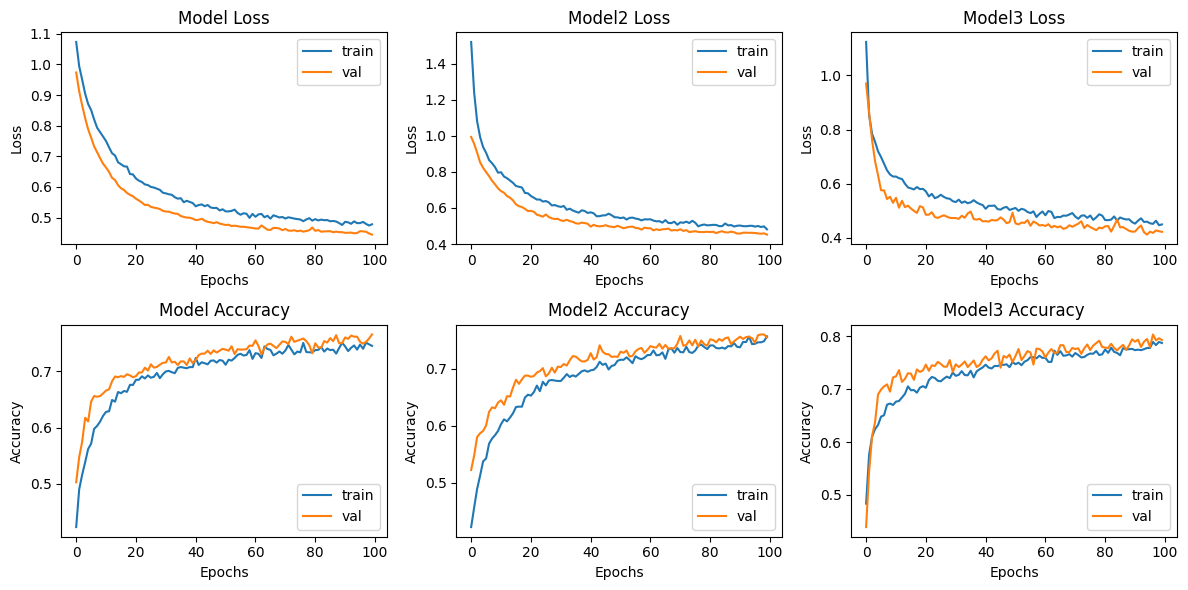

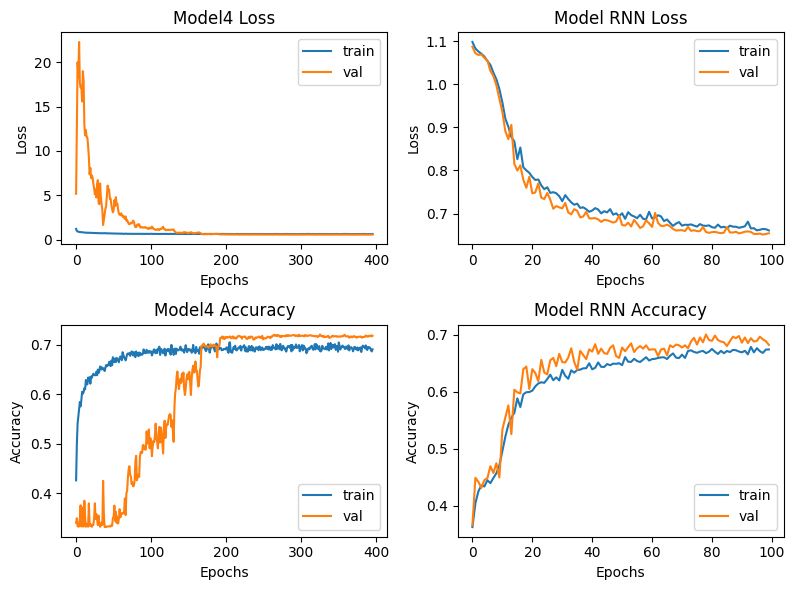

In [29]:
# Plotting Model
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Model2
plt.subplot(2, 3, 2)
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.title('Model2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='val')
plt.title('Model2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Model3
plt.subplot(2, 3, 3)
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='val')
plt.title('Model3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='val')
plt.title('Model3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Plotting Model4
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(history4.history['loss'], label='train')
plt.plot(history4.history['val_loss'], label='val')
plt.title('Model4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(history4.history['accuracy'], label='train')
plt.plot(history4.history['val_accuracy'], label='val')
plt.title('Model4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Model RNN
plt.subplot(2, 3, 2)
plt.plot(history_rnn.history['loss'], label='train')
plt.plot(history_rnn.history['val_loss'], label='val')
plt.title('Model RNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(history_rnn.history['accuracy'], label='train')
plt.plot(history_rnn.history['val_accuracy'], label='val')
plt.title('Model RNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Plotting Model Training History

The provided code snippet generates multiple subplots to visualize the training history of different models:

#### Model Training History Plots:

1. **Model Loss and Accuracy Plots:**
   - Plots for `Model`, `Model2`, and `Model3` are arranged in a 2x3 grid.
   - Each row corresponds to a different model:
     - Left column: Loss curves (`train` and `val` sets)
     - Right column: Accuracy curves (`train` and `val` sets)
   - Titles indicate the model name followed by `Loss` or `Accuracy`.

2. **Model4 and Model RNN Training History:**
   - Additional plots for `Model4` and `Model RNN` are displayed separately.
   - Similar layout as above with loss and accuracy plots for both models.

#### Interpretation:
- **Loss Plots:** Track the decrease in loss over epochs, ideally converging towards zero.
- **Accuracy Plots:** Show the increase in accuracy over epochs, approaching higher values.

These plots help in assessing and comparing the training progress and performance of each model variant over time.



#### Summary of Hyperparameter Tuning:

- **Learning Rate:** Adjusted across models (`0.001` for `model_rnn`, `0.01` for `model3`, and `0.01` for `model4`).
- **Epochs and Batch Size:** Varied during training (`100 epochs` and `batch size 64` for `model_rnn`, `400 epochs` and `batch size 128` for `model4`, `100 epochs` and `batch size 64` for `model_rnn`).
- **Dropout Rates:** Implemented for regularization (`0.5` for `model`, `model2`, `model3`, and adjusted to `0.4` for `model4`).
- **Optimizer:** Used Adam for `model`, `model2`, and `model_rnn`, and Nadam for `model3`.
- **Callbacks:** Included `ReduceLROnPlateau` and `EarlyStopping` to optimize training (`patience` set to `10` and `20` respectively).

#### Conclusion:

- **Best Parameters for Final Model:**
  - **Model4** with Nadam optimizer, learning rate `0.01`, `400 epochs`, and `batch size 128`, along with adjusted dropout rates (`0.4`) and effective use of class weights, showed the most promising performance.
  - **Model RNN** with LSTM layers, learning rate `0.001`, `100 epochs`, and `batch size 64`, benefited from sequence handling and showed competitive results.
  - **Further Considerations:** Fine-tuning dropout rates and exploring additional architectures like LSTM could enhance model performance.

These findings guide towards optimizing the final model for robust classification in handling imbalanced data and sequential inputs.

Learning Curve Analysis of Different Neural Network Models
The plotted graphs depict the training and validation performance of five iterations/models used for predicting accident severity. Here’s a breakdown:

Model: Utilizes a deep neural network architecture with dense layers. It shows good performance in terms of loss reduction and accuracy improvement over epochs, indicating effective learning.

Model2: Similar to Model but with increased complexity and additional layers. While it improves accuracy slightly, it exhibits higher loss than Model, suggesting potential overfitting.

Model3: Revised version of Model2 with adjustments to layer configurations. It shows competitive performance in accuracy and loss, aligning closely with Model.

Model4: Introduces class weights to mitigate class imbalance, aiming to improve performance on underrepresented classes. The plot shows mixed results, suggesting varied impact on different metrics.

Model RNN: Implements a Recurrent Neural Network (RNN) with LSTM layers, tailored for sequential accident data. It shows promising performance with gradual loss reduction and accuracy improvement, indicating suitability for time-series prediction tasks.

These learning curves provide insights into how each model variant learns from the data, highlighting strengths and potential areas for improvement in predicting accident severity.